News Category Classification

In [8]:
#import dataset

import pandas as pd

df = pd.read_csv('AG_News.csv')
df = df.head(10000)

In [9]:
# preprocess the dataset

import spacy

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    text = text.replace("reuter", "").replace("reuters", "")
    doc = nlp(text.lower())

    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]

    return " ".join(tokens)

df['Title'] = df['Title'].apply(preprocess)
print("'Title' preprocessed!")
df['Description'] = df['Description'].apply(preprocess)
print("'Description' preprocessed!")

'Title' preprocessed!
'Description' preprocessed!


In [10]:
# remove rows with empty, NaN, null and "" columns

df.replace("", pd.NA, inplace=True)
df.dropna(inplace=True)

In [11]:
# generate file for the preprocessed dataset (just in case)

df.to_csv("preprocessed_AG_News.csv", index=False)

In [36]:
# convert the title and description columns into TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_title = TfidfVectorizer()
vectorizer_desc = TfidfVectorizer()

title = vectorizer_title.fit_transform(df['Title'])
description = vectorizer_desc.fit_transform(df['Description'])

In [37]:
# combine TF-IDF features from title and description into a single sparse matrix

from scipy.sparse import hstack

X = hstack([title, description])
y = df['Class Index'].values

In [38]:
# splitting dataset for testing and training sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# trains logistic regression classifier on training data

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100)
clf.fit(X_train, y_train)

# model performance evaluation (logistic regression classifier)

from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4']))
print("Logistic Regression:", accuracy_score(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.86      0.89       545
           2       0.92      0.97      0.95       445
           3       0.89      0.84      0.86       493
           4       0.86      0.92      0.89       515

    accuracy                           0.90      1998
   macro avg       0.90      0.90      0.90      1998
weighted avg       0.90      0.90      0.90      1998

Logistic Regression: 0.8973973973973974


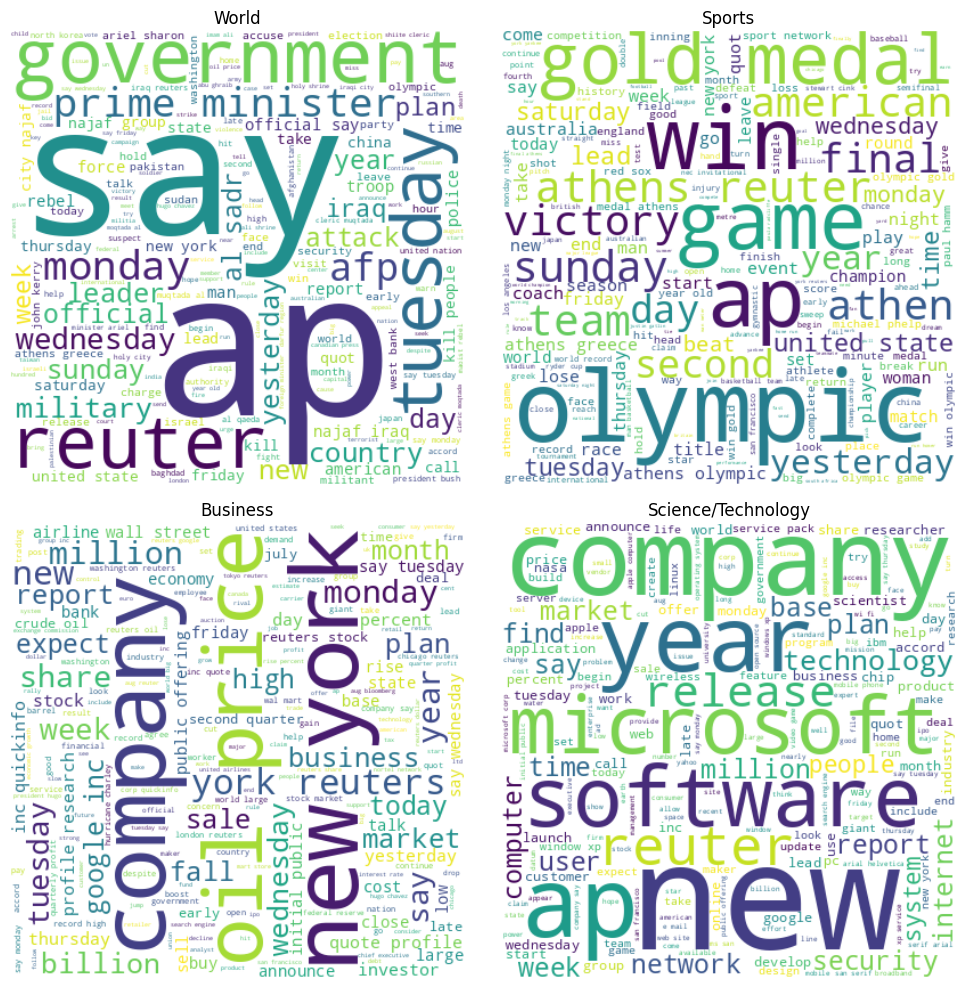

In [40]:
# bonus: visualizing most frequently used words in each class

import matplotlib.pyplot as plt
from wordcloud import WordCloud

world_text = ' '.join(df[df['Class Index'] == 1]['Description'].dropna().astype(str))
sports_text = ' '.join(df[df['Class Index'] == 2]['Description'].dropna().astype(str))
business_text = ' '.join(df[df['Class Index'] == 3]['Description'].dropna().astype(str))
science_text = ' '.join(df[df['Class Index'] == 4]['Description'].dropna().astype(str))

world_wc = WordCloud(width=400, height=400, background_color='white').generate(world_text)
sports_wc = WordCloud(width=400, height=400, background_color='white').generate(sports_text)
business_wc = WordCloud(width=400, height=400, background_color='white').generate(business_text)
science_wc = WordCloud(width=400, height=400, background_color='white').generate(science_text)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(world_wc, interpolation='bilinear')
plt.title('World')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(sports_wc, interpolation='bilinear')
plt.title('Sports')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(business_wc, interpolation='bilinear')
plt.title('Business')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(science_wc, interpolation='bilinear')
plt.title('Science/Technology')
plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
# bonus: training the model using a neural network and evaluating

df['processed'] = df['Title'] + " " + df['Description']
X_raw = df['processed'].values
y = df['Class Index'].values - 1

from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, padding='post')
X_test_pad = pad_sequences(X_test_seq, padding='post')

from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense

vocab_size = len(tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3413 - loss: 1.3438 - val_accuracy: 0.8273 - val_loss: 0.7563
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8201 - loss: 0.6944 - val_accuracy: 0.8679 - val_loss: 0.4085
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8825 - loss: 0.3859 - val_accuracy: 0.8789 - val_loss: 0.3587
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9104 - loss: 0.2830 - val_accuracy: 0.8784 - val_loss: 0.3572
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9241 - loss: 0.2413 - val_accuracy: 0.8879 - val_loss: 0.3525
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9431 - loss: 0.1811 - val_accuracy: 0.8924 - val_loss: 0.3398
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9536 - loss: 0.1494 - val_accuracy: 0.8854 - val_loss: 0.3534
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9667 - loss: 0.1163 - val_accu